Mini-Batch AUC Optimization (MBA)
=================

A comparison of Mini-Batch AUC Optimization (MBA) with Online Logistic Regression (ONLR) on a sample dataset.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score
from tqdm import tqdm

In [2]:
#load svmguide dataset
#this data has 21 features
train_path, test_path, no_feat = './data/data_train', './data/data_test', 21
X_train, y_train = load_svmlight_file(train_path, no_feat)
X_test, y_test = load_svmlight_file(test_path, no_feat)

X_train = np.asarray( X_train.todense() )
X_test = np.asarray( X_test.todense() )

y_train_01 = .5*(y_train+1)
y_test_01 = .5*(y_test+1)

In [3]:
#Online logistic regression
class ONLR:
    def __init__(self, no_feat, lam2):
        self.weig = np.zeros(no_feat + 1)
        self.lam2 = lam2
        self.err = []    
    
    
    def predict(self, x):
        x_aug = np.append(x, 1.0)
        return 1.0 / ( 1.0 + np.exp(-np.dot(self.weig, x_aug)) )
    
    
    def update(self, x, y, step_size):
        x_aug = np.append( x , 1.0 ) #add bias term to end 
        y_hat = self.predict(x)    
        grd = (y_hat-y)*x_aug + self.lam2*self.weig
        self.weig = self.weig - step_size*grd
    
     
    def rec_err(self, X_train, y_train):
        Xw = X_train.dot(self.weig[:-1]) + self.weig[-1]
        p1, p2 = np.log(1 + np.exp(-Xw)), np.log(1 + np.exp(Xw))
        self.err.append( np.dot(y_train, p1) + np.dot(1-y_train, p2) )

In [55]:
clf = ONLR(no_feat, 1e-4) #L2 regularization set from paper
#for the best performance use slow learning rate and large number of iterations
#the problem is convex so there is a unique solution
step_size = 1e-3
for i in tqdm(xrange(100*X_train.shape[0])):
    sel = np.random.choice(X_train.shape[0])
    clf.update(X_train[sel,:], y_train_01[sel], step_size)
    if (i+1)%10==0:
        clf.rec_err(X_train,y_train_01)    

100%|██████████| 64200/64200 [00:02<00:00, 28444.84it/s]


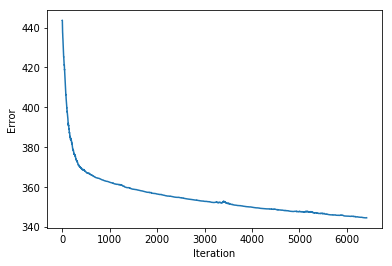

In [56]:
plt.figure()
plt.plot(clf.err)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

In [57]:
print('AUC of ONLR')
y_test_hat = np.array([])
for i in range(X_test.shape[0]):
    y_test_hat = np.append(y_test_hat, clf.predict(X_test[i,:]))
print(roc_auc_score(y_test,y_test_hat))

AUC of Logistic Regression
0.660320002002


In [128]:
#Mini-Batch AUC Optimization

class MBA:
    def __init__(self, lam2, mb_size, no_iter):
        self.lam2 = lam2
        self.mb_size = mb_size
        self.no_iter = no_iter
        self.apprx_mean = None
        self.apprx_cov = None
        self.weig = None
    
    def apprx_moments(self, Xp, Xm):
        apprx_mean = np.zeros(Xp.shape[0])
        apprx_cov = np.zeros((Xp.shape[0], Xp.shape[0]))    
        for i in xrange(self.no_iter):
            Xp_sub = Xp[:, np.random.choice(Xp.shape[1], self.mb_size, replace=True)]
            Xm_sub = Xm[:, np.random.choice(Xm.shape[1], self.mb_size, replace=True)]
            Xdif = Xp_sub - Xm_sub
            apprx_mean = apprx_mean + (1.0/self.mb_size)*np.sum(Xdif, axis=1)
            apprx_cov = apprx_cov + (1.0/self.mb_size)*np.dot(Xdif,Xdif.T)        
        apprx_mean = (1.0/self.no_iter)*apprx_mean
        apprx_cov = (1.0/self.no_iter)*apprx_cov    
        self.apprx_mean = apprx_mean
        self.apprx_cov = apprx_cov
    
    
    def train(self, Xp, Xm):
        self.apprx_moments(Xp, Xm)
        self.weig = np.linalg.inv(self.lam2*np.eye(self.apprx_cov.shape[0]) + \
                             self.apprx_cov).dot(self.apprx_mean)
    
    
    def predict(self, x):
        return np.dot(self.weig, x)

In [132]:
#split positive and negative instances
Xp, Xm = X_train[np.where(y_train > 0)].T, X_train[np.where(y_train < 0)].T

clf = MBA(1e-6, X_train.shape[0], 1) #L2 regularization set from paper
clf.train(Xp, Xm)  

<type 'numpy.ndarray'>


In [134]:
print('AUC of MBA')
y_test_hat = np.array([])
for i in range(X_test.shape[0]):
    y_test_hat = np.append(y_test_hat, clf.predict(X_test[i,:]))
print(roc_auc_score(y_test,y_test_hat))

AUC of MBA
0.804008156423


Conclusion
======

* AUC of ONLR = 66 %
* AUC of MBA = 80%
* MBA achieves 14% better AUC compared to ONLR.
* ONLR requires 100 times more samples than MBA to reach 66%.
* ONLR can get competitive performance if we use 1000 more samples!

In [135]:
#Demo with 1000x samples
clf = ONLR(no_feat, 1e-4) #L2 regularization set from paper
#for the best performance use slow learning rate and large number of iterations
#the problem is convex so there is a unique solution
step_size = 1e-3
for i in tqdm(xrange(1000*X_train.shape[0])):
    sel = np.random.choice(X_train.shape[0])
    clf.update(X_train[sel,:], y_train_01[sel], step_size)
    if (i+1)%10==0:
        clf.rec_err(X_train,y_train_01) 

100%|██████████| 642000/642000 [00:22<00:00, 29169.88it/s]


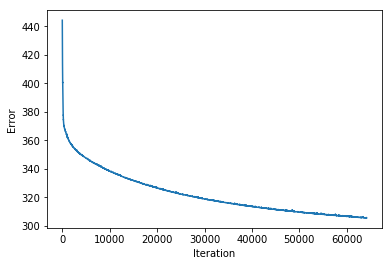

In [136]:
plt.figure()
plt.plot(clf.err)
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.show()

In [137]:
print('AUC of ONLR with 1000x Samples')
y_test_hat = np.array([])
for i in range(X_test.shape[0]):
    y_test_hat = np.append(y_test_hat, clf.predict(X_test[i,:]))
print(roc_auc_score(y_test,y_test_hat))

AUC of ONLR with 1000x Samples
0.781202697124
